# Lab 2
Lucas Street, 1874989

In [81]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import pandas as pd
from scipy import stats

## Problem 1
Let us assume the average number of cosmic background rays seen per day from a telescope is 4.5, and the average number of gamma rays per day emitted by a hypothetical source is 6.

In [82]:
avg_daily_cosmic_rays = 4.5
avg_daily_gamma_rays = 6

Let us also assume the cosmic background is Poisson-distributed; we can plot its probability mass function (PMF).

In [83]:
dist = stats.poisson(avg_daily_cosmic_rays)
x = np.arange(0, 20)
pmf = dist.pmf(x)

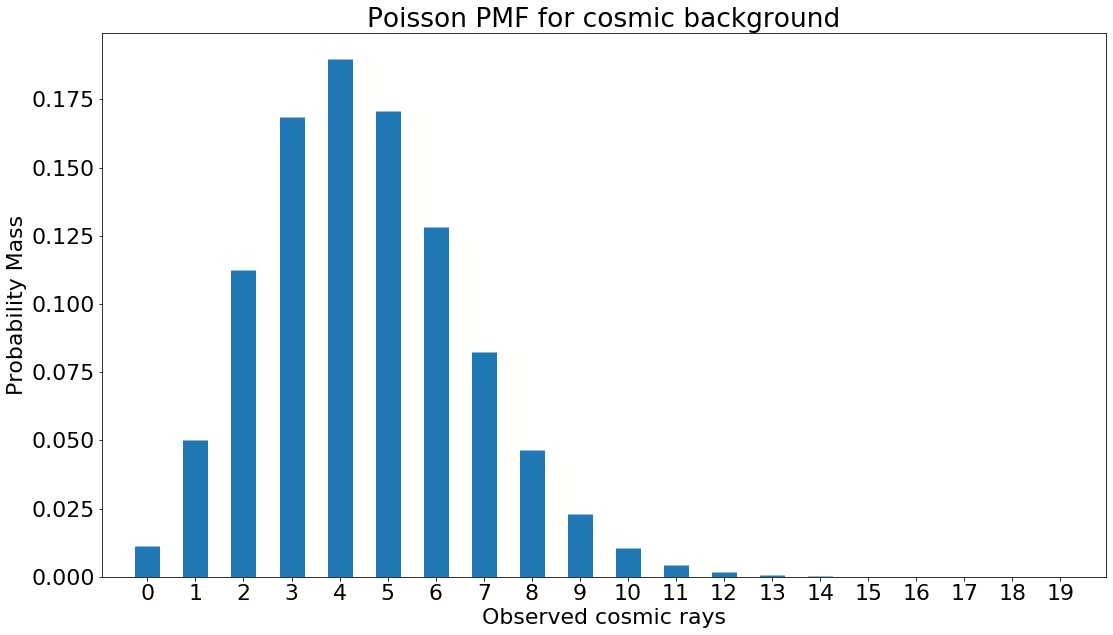

In [84]:
plt.title("Poisson PMF for cosmic background")
plt.xlabel("Observed cosmic rays")
plt.ylabel("Probability Mass")
plt.vlines(x, 0, pmf, linewidth=25, color="C0")
plt.xticks(x)
plt.ylim(0, None);

To show how this distribution changes as we integrate for several days, we will plot the distribution corresponding to the expected number of cosmic rays seen after $n$ days. To do this, we convolve the distribution with itself for the given number of days.

In [85]:
def plot_sum(pmf, n, *args, **kwargs):
    new_pmf = pmf
    for i in range(n):
        new_pmf = np.convolve(new_pmf, pmf)
    plt.vlines(range(len(new_pmf)), 0, new_pmf, *args, **kwargs)
    plt.xlim(0, None)
    plt.ylim(0, None)

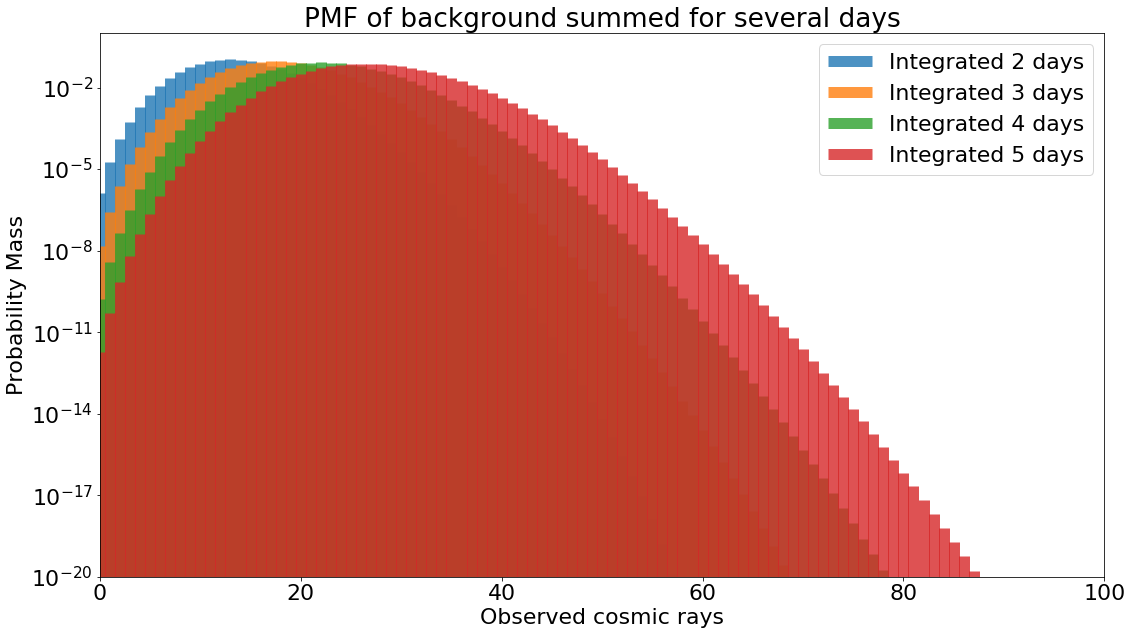

In [86]:
x = np.arange(0, 20)
for i in range(2, 6):
    plot_sum(dist.pmf(x), i, linewidth=11, color=f"C{i - 2}", alpha=0.8)
plt.title("PMF of background summed for several days")
plt.xlabel("Observed cosmic rays")
plt.ylabel("Probability Mass")
plt.legend([f"Integrated {i} days" for i in range(2, 6)])
plt.yscale('log')
plt.xlim(0, 100)
plt.ylim(1e-20, 1);

After integrating for 5 days, notice the distribution still has the characteristic "tail" on the right side that comes with a Poisson distribution. Conceptually, this makes sense: the Poisson distribution describes the independent probability of discrete events occurring over some time interval. In this case, integrating for 5 days will only add 5 of these independent variables together, so we still expect the distribution to retain a Poisson-like shape.

Mathematically, this makes sense because the convolution of multiple Poisson distributions is just the Poisson distribution of the sum of the $\lambda$'s of the distributions we're convolving. In other words, $\sum\limits_{i=1}^{n} Poisson(\lambda_i) = Poisson(\sum\limits_{i=0}^{n} \lambda_i)$ (Source: [Wikipedia](https://en.wikipedia.org/wiki/List_of_convolutions_of_probability_distributions)).

What if we _average_ the number of cosmic rays observed per day? For this, we convolve the distribution with itself $n$ times given $n$ additional days.

In [87]:
def plot_average(pmf, n, *args, **kwargs):
    new_pmf = pmf
    for i in range(n):
        new_pmf = np.convolve(new_pmf, pmf)
    plt.vlines(np.linspace(0, 20, len(new_pmf)), 0, new_pmf, *args, **kwargs)
    plt.xlim(0, None)
    plt.ylim(0, None)

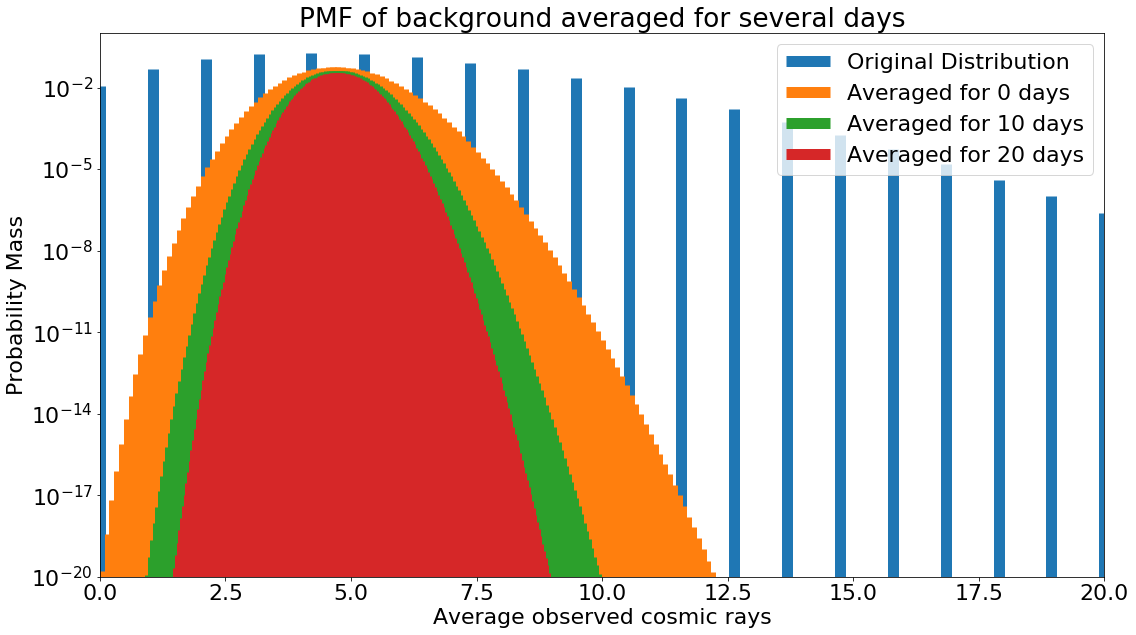

In [88]:
days = [0, 10, 20, 30]
for i in days:
    plot_average(pmf, i, linewidth=11, color=f"C{i // 10}")
plt.title("PMF of background averaged for several days")
plt.xlabel("Average observed cosmic rays")
plt.ylabel("Probability Mass")
plt.legend(['Original Distribution', *[f"Averaged for {n} days" for n in days]])
plt.yscale('log')
plt.xlim(0, 20)
plt.ylim(1e-20, 1);

For larger $n$, the distribution shrinks and converges around its mean, into what looks like a Gaussian PDF. The shrinking makes sense, since the more we average, the more possible values there are for observing cosmic rays, and the probability masses are distributed out to each value accordingly.

What happens if we pick an even larger value of $n$, like 300 days?

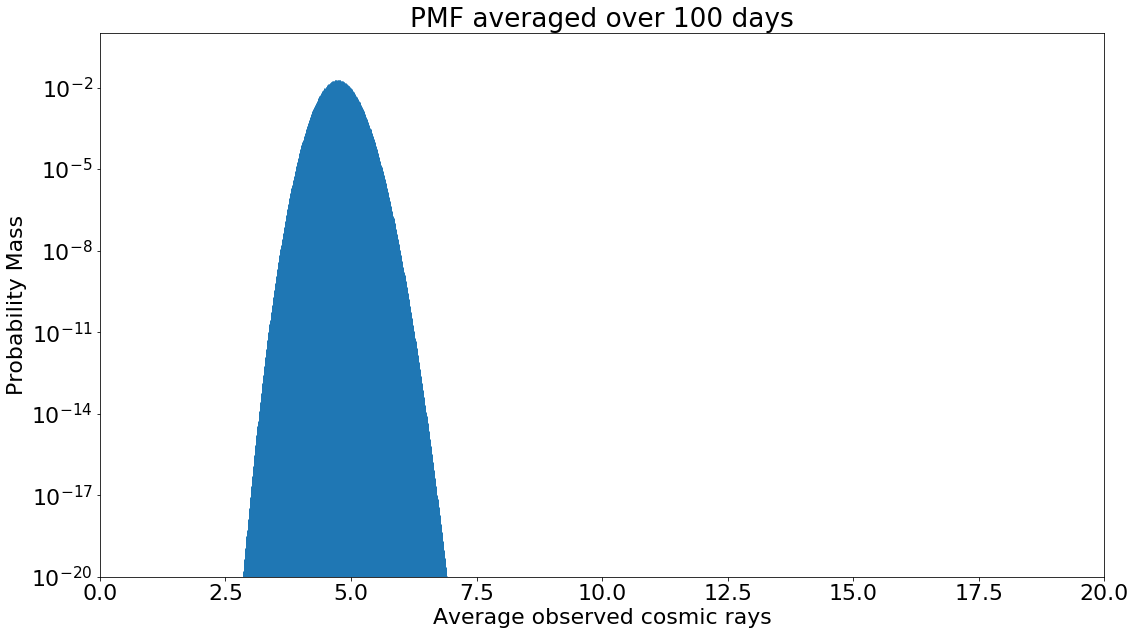

In [116]:
n = 300
plot_average(pmf, n, linewidth=1, color='C0')
plt.title(f"PMF averaged over {n} days")
plt.xlabel("Average observed cosmic rays")
plt.ylabel("Probability Mass")
plt.yscale('log')
plt.xlim(0, 20)
plt.ylim(1e-20, 1);

Now it is much narrower and more Gaussian-shaped than Poisson-shaped, since it appears as a downward parabola on a log scale. The central limit theorem says that for some situations, repeated convolution of a distribution like we did above will eventually cause the distribution to converge to a Gaussian distribution. In relation to when we summed the distribution earlier, repeated summing for a large $n$ will also approximate a Gaussian distribution, since the limiting case of the Poisson distribution for large $\lambda$ is a Gaussian distribution.

Let's choose to wait 10 days, and say we observe what appears to be 60 gamma rays (10 days * 6 gamma rays/day). What is the 'sigma' of this observation? That is, what is the probability that my cosmic ray background data gave me something that _looked_ like 60 or more gamma rays instead? The probability that we saw 60 or more cosmic rays in 2 days from the background is the integral of the PMF summed for 1 day, from 60 to infinity. It is simpler, however, to use the survival function, 1 minus the cumulative distribution function.

In [90]:
# New distribution has an average of 10 * 4.5 = 45
# We're taking 1 - CDF, UP TO 60, not including 60, otherwise we'd lose 
prob = stats.poisson(45).sf(60 - 1)
print(prob)

0.018651134648575467


About 1.9%. Let's convert this to the form $X\sigma$ using the `ppf` function of the standard normal distribution.

In [91]:
stats.norm.ppf(1 - prob)

2.082440314519667

Therefore, the probability is $2.08\sigma$.

## Problem 2

Let's assume we have a new kind of measurement where our background has a skewed continuous distribution, like the Rayleigh distribution: $P(x) = \frac{x}{\sigma^2} e^{\frac{-x^2}{2\sigma^2}}$, where $\sigma$ is called the scale parameter. Let's set $\sigma = 1$ and plot the PDF of the distribution.

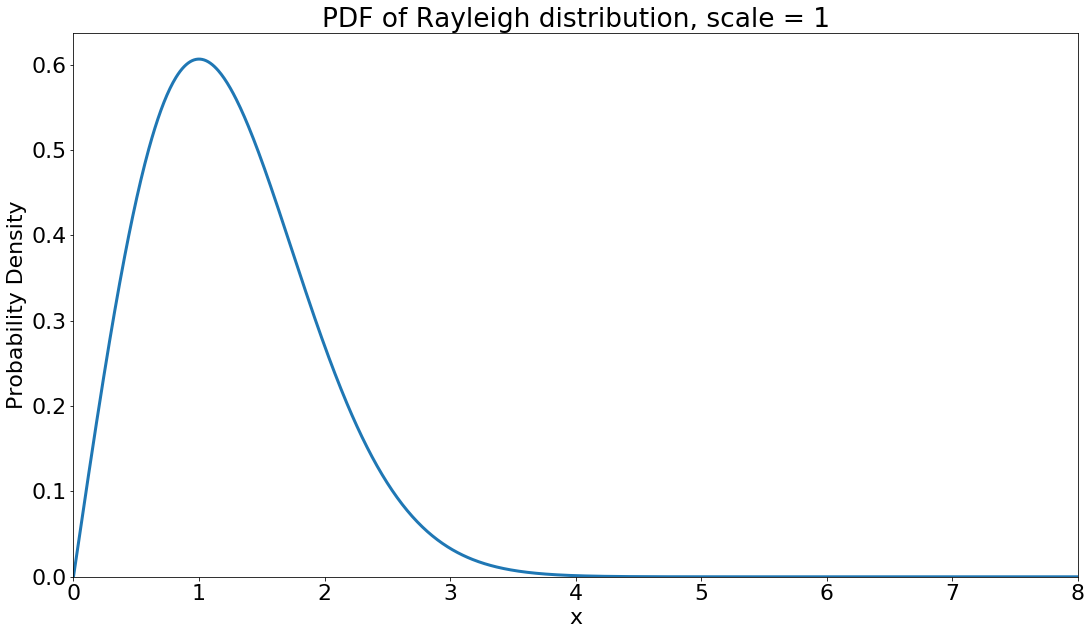

In [92]:
scale = 1
dist = stats.rayleigh(scale=scale)
x = np.linspace(0, 8, 1000)
plt.title(f"PDF of Rayleigh distribution, scale = {scale}")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.plot(x, dist.pdf(x), linewidth=3)
plt.xlim(0, 8)
plt.xticks(range(0, 9))
plt.ylim(0, None);

Now let's average over more observing intervals by convolving the distribution with itself, just as we did before with the Poisson distribution.

In [93]:
def plot_average_rayleigh(x, pdf, n, *args, **kwargs):
    new_pdf = pdf
    for i in range(n):
        new_pdf = np.convolve(new_pdf, pdf)
    plt.plot(np.linspace(x[0], x[-1], len(new_pdf)), new_pdf, *args, **kwargs)
    plt.xlim(x[0], x[-1])

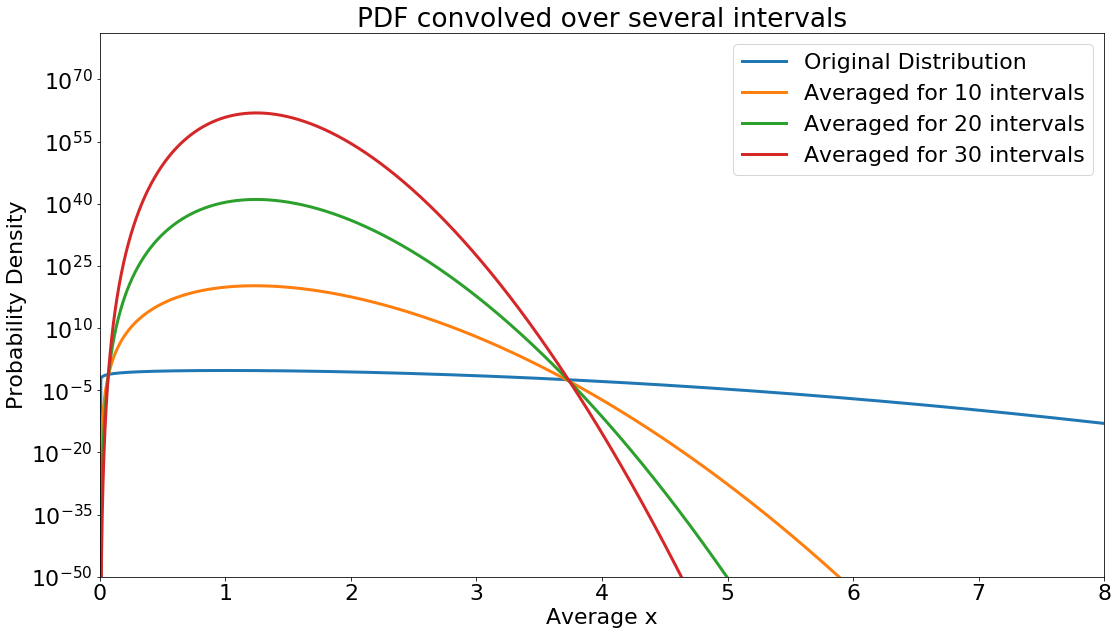

In [94]:
pdf = dist.pdf(x)
nums = [0, 10, 20, 30]
for i in nums:
    plot_average_rayleigh(x, pdf, i, linewidth=3)
plt.title("PDF convolved over several intervals")
plt.xlabel("Average x")
plt.ylabel("Probability Density")
plt.yscale('log')
plt.ylim(1e-50, None);
plt.legend(['Original Distribution', *[f"Averaged for {n} intervals" for n in nums[1:]]]);

The shapes of the distributions get taller and narrower, but they still have that "Rayleigh tail" on the right side of the peak. Because each PDF does not appear as a downward parabola on the log scale, they don't look Gaussian yet. What happens if we try a larger number of convolutions, say, 300?

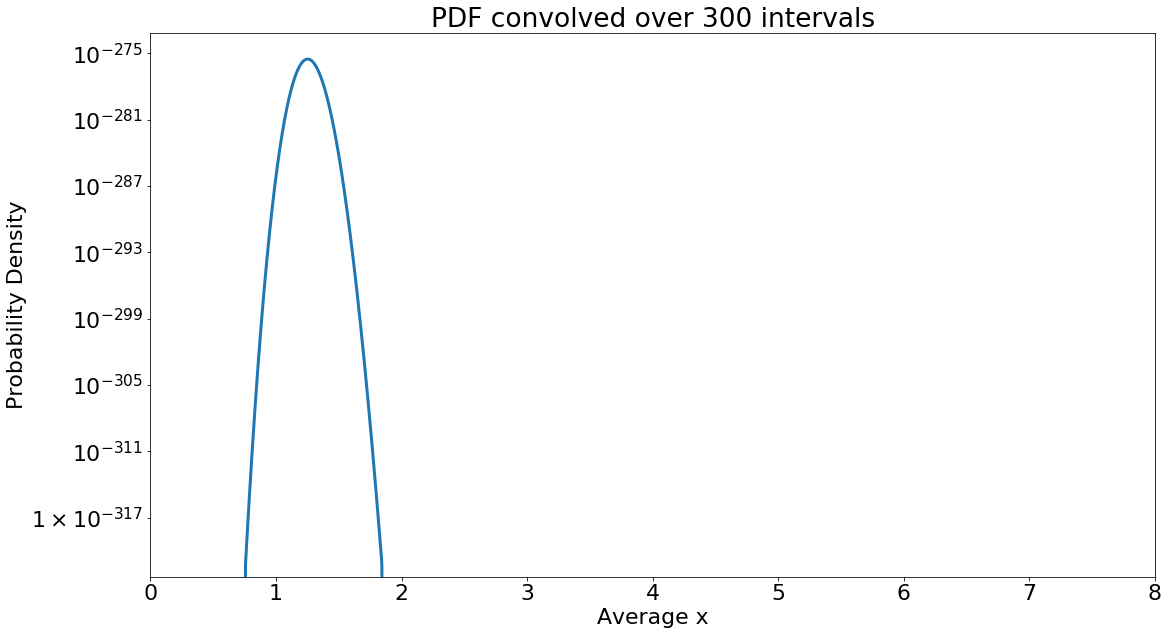

In [121]:
n = 300
# Divide original PDF by 1000 in order to not melt my computer
plot_average_rayleigh(x, pdf / 1000, n, linewidth=3)
plt.title(f"PDF convolved over {n} intervals")
plt.xlabel("Average x")
plt.ylabel("Probability Density")
plt.yscale('log');

After convolving it over 300 intervals, it has begun to look parabolic on a log scale, indicating that it has approached an approximately Gaussian distribution. Note that I had to scale down the original PDF by 1000 times just to be able to fit the plot on screen without causing a meltdown due to numeric overflow. The shape of the distribution, however, should be unaffected.

## Problem 3